# Model Iteration 2

Negations have come up time and time again to be a factor that causes phrases to be mis-categorized. In order to handle these cases, I will prepend a "NOT\_" to the beginning of all the words that come after a negation phrase (these include "not", "but", "didn't" among others).

In [41]:
%matplotlib inline
import pandas

df = pandas.DataFrame.from_csv('train.tsv', sep='\t')

In [2]:
df.head()

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2
4,1,A,2
5,1,series,2


In [3]:
import re

def prepend_NOT(match):
    """
    A function that feeds into a regular expression substitution function
    that prepends all words after a negation word (i.e. "didn't" and
    "not") with "NOT_".
    """
    match = match.group()
    words = match.split(" ")
    negation = words[0]
    del words[0]
    new_words = ["NOT_" + word for word in words]
    return negation + " " + " ".join(new_words)


def substitute_negations(phrase):
    """
    Replaces input phrase with the same phrase, except prepending a "NOT_"
    for every word after a negation word (i.e. "didn't" and "not"). This
    can only occur in phrases with more than one word.
    """
    # negation_words is a list of regular expressions
    negation_words = [r"not", r"n't"]
    
    # negation_words then gets turned into a regular expression string
    negation_words = [r"(" + word + r")" for word in negation_words]
    negation_words = (r"|").join(negation_words)
    
    negations_re = re.compile(r"(" + negation_words + r")[A-z ']*")
    substitution = negations_re.sub(prepend_NOT, phrase)
    
    if substitution == "":
        return phrase
    return substitution


def add_NOT_to_negations(df):
    """
    Replaces each phrase in the dataframe with the same phrase, but
    replacing every word after a negation word (i.e. "didn't" and "not")
    with "NOT_" prepended to the word. This can only occur in phrases
    with more than one word.
    """
    data = df
    data["Negations"] = data["Phrase"].apply(lambda x: substitute_negations(x))
    return data

In [4]:
df01 = add_NOT_to_negations(df)

In [5]:
df01.drop_duplicates(['SentenceId']).head(10)

,SentenceId,Phrase,Sentiment,Negations
PhraseId,,,,
1,1,A series of escapades demonstrating the adage ...,1,A series of escapades demonstrating the adage ...
64,2,"This quiet , introspective and entertaining in...",4,"This quiet , introspective and entertaining in..."
82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,"Even fans of Ismail Merchant 's work , I suspe..."
117,4,A positively thrilling combination of ethnogra...,3,A positively thrilling combination of ethnogra...
157,5,Aggressive self-glorification and a manipulati...,1,Aggressive self-glorification and a manipulati...
167,6,A comedy-drama of nearly epic proportions root...,4,A comedy-drama of nearly epic proportions root...
199,7,"Narratively , Trouble Every Day is a plodding ...",1,"Narratively , Trouble Every Day is a plodding ..."
214,8,"The Importance of Being Earnest , so thick wit...",3,"The Importance of Being Earnest , so thick wit..."
248,9,But it does n't leave you with much .,1,But it does n't NOT_leave NOT_you NOT_with NOT...


Now, I would like to see if I can improve sentiment analysis by extracting what part of speech each word is. Part of speech (POS) tagging is an extensively studied NLP topic, however, each sentence is only tagged correctly probably just over 50% of the time (according to <a href="http://nlp.stanford.edu/pubs/CICLing2011-manning-tagging.pdf">this paper</a>. I will use the well-rounded Perceptron Tagger implemented in the NLTK library.

In [6]:
from nltk.tag.perceptron import PerceptronTagger

# Load the tagger for faster tagging
tagger = PerceptronTagger()

In [7]:
import nltk

def tag_all_phrases(df):
    data = df
    data["POS"] = data["Phrase"].apply(
        lambda x: [tag[1] for tag in \
                   nltk.tag._pos_tag(nltk.word_tokenize(x), None, tagger)] )
    return data

In [8]:
df02 = tag_all_phrases(df01)

In [9]:
df02.drop_duplicates(["SentenceId"]).head(10)

,SentenceId,Phrase,Sentiment,Negations,POS
PhraseId,,,,,
1,1,A series of escapades demonstrating the adage ...,1,A series of escapades demonstrating the adage ...,"[DT, NN, IN, NNS, VBG, DT, NN, IN, WP, VBZ, JJ..."
64,2,"This quiet , introspective and entertaining in...",4,"This quiet , introspective and entertaining in...","[DT, JJ, ,, JJ, CC, JJ, JJ, VBZ, JJ, VBG, .]"
82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,"Even fans of Ismail Merchant 's work , I suspe...","[RB, NNS, IN, NNP, NNP, POS, NN, ,, PRP, VBP, ..."
117,4,A positively thrilling combination of ethnogra...,3,A positively thrilling combination of ethnogra...,"[DT, RB, VBG, NN, IN, NN, CC, PDT, DT, NN, ,, ..."
157,5,Aggressive self-glorification and a manipulati...,1,Aggressive self-glorification and a manipulati...,"[JJ, NN, CC, DT, JJ, NN, .]"
167,6,A comedy-drama of nearly epic proportions root...,4,A comedy-drama of nearly epic proportions root...,"[DT, NN, IN, RB, JJ, NNS, VBN, IN, DT, JJ, NN,..."
199,7,"Narratively , Trouble Every Day is a plodding ...",1,"Narratively , Trouble Every Day is a plodding ...","[RB, ,, JJ, DT, NNP, VBZ, DT, VBG, NN, .]"
214,8,"The Importance of Being Earnest , so thick wit...",3,"The Importance of Being Earnest , so thick wit...","[DT, NN, IN, NNP, NNP, ,, RB, JJ, IN, NN, PRP,..."
248,9,But it does n't leave you with much .,1,But it does n't NOT_leave NOT_you NOT_with NOT...,"[CC, PRP, VBZ, RB, VB, PRP, IN, JJ, .]"


This would be much easier to analyze if I could get the tags of the individual words. So I will, for human analysis sake.

In [10]:
def get_words(df):
    data = df[~(df['Phrase'].str.contains(' '))]
    return data

In [11]:
df02_words = get_words(df02)

In [12]:
df02_words.head(10)

,SentenceId,Phrase,Sentiment,Negations,POS
PhraseId,,,,,
4,1,A,2,A,[DT]
5,1,series,2,series,[NN]
7,1,of,2,of,[IN]
9,1,escapades,2,escapades,[NNS]
12,1,demonstrating,2,demonstrating,[VBG]
14,1,the,2,the,[DT]
15,1,adage,2,adage,[NN]
17,1,that,2,that,[IN]
19,1,what,2,what,[WP]


Now I want to know all of the unique parts of speech in the words of this corpus. Unfortunately, the POS column is a list, which is not hashable, preventing me from using built-in pandas library functions. So I extract each POS and make a new column called POS2.

In [13]:
def extract_single_POS_from_words(df):
    data = df
    data["POS2"] = data["POS"].apply(lambda x: x[0])
    return data

In [14]:
df02_words01 = extract_single_POS_from_words(df02_words)

-c:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
df02_words01.head(10)

,SentenceId,Phrase,Sentiment,Negations,POS,POS2
PhraseId,,,,,,
4,1,A,2,A,[DT],DT
5,1,series,2,series,[NN],NN
7,1,of,2,of,[IN],IN
9,1,escapades,2,escapades,[NNS],NNS
12,1,demonstrating,2,demonstrating,[VBG],VBG
14,1,the,2,the,[DT],DT
15,1,adage,2,adage,[NN],NN
17,1,that,2,that,[IN],IN
19,1,what,2,what,[WP],WP


In [16]:
for pos in df02_words01['POS2'].unique():
    print pos

DT
NN
IN
NNS
VBG
WP
VBZ
JJ
RB
,
WDT
CC
TO
.
POS
PRP
MD
VB
CD
VBN
NNP
EX
PRP$
VBP
RBR
:
JJS
``
''
WRB
VBD
JJR
WP$
$
UH
SYM
LS
#
FW


I'll use the <a href="https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html">part of speech tags used by the Penn Treebank</a> as a reference for what the tags mean. Now I'll make a column for each of these unique parts of speech which represents whether or not that word is using this part of speech. It will be sparse for the most part (there will be many zeros).

In [17]:
import numpy as np

def make_POS_columns(df):
    data = df
    for pos in df['POS2'].unique():
        data[pos] = np.asarray((df['POS2'] == pos), dtype=int)
    return data

In [18]:
df02_words02 = make_POS_columns(df02_words01)

-c:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
df02_words02.head(10)

,SentenceId,Phrase,Sentiment,Negations,POS,POS2,DT,NN,IN,NNS,...,WRB,VBD,JJR,WP$,$,UH,SYM,LS,#,FW
PhraseId,,,,,,,,,,,,,,,,,,,,,
4,1,A,2,A,0,DT,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,series,2,series,0,NN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,of,2,of,0,IN,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,1,escapades,2,escapades,0,NNS,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12,1,demonstrating,2,demonstrating,0,VBG,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,the,2,the,0,DT,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,adage,2,adage,0,NN,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1,that,2,that,0,IN,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19,1,what,2,what,0,WP,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's look at how the adjectives compare in terms of sentiment.

In [31]:
adjectives = df02_words02[(df02_words02['POS2'] == 'JJ') |\
             (df02_words02['POS2'] == 'JJR') |\
             (df02_words02['POS2'] == 'JJS')]

In [32]:
adjectives.head()

,SentenceId,Phrase,Sentiment,Negations,POS,POS2,DT,NN,IN,NNS,...,WRB,VBD,JJR,WP$,$,UH,SYM,LS,#,FW
PhraseId,,,,,,,,,,,,,,,,,,,,,
23,1,good,3,good,0,JJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,1,much,2,much,0,JJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69,2,quiet,2,quiet,0,JJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,2,introspective,2,introspective,0,JJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,2,independent,2,independent,0,JJ,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


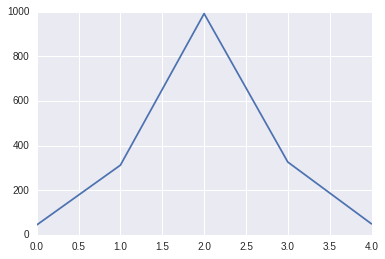

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

adj_sentiments = [np.sum(np.asarray([1 if j == i else 0\
                                  for j in adjectives['Sentiment']], dtype=int))\
                  for i in range(5)]
plt.plot(adj_sentiments)
plt.show()

The sentiment of the whole phrase could possibly be gleaned by weighting the sentiments of the adjectives. Maybe even the adverbs as well.

In [43]:
adverbs = df02_words02[(df02_words02['POS2'] == 'RB') |\
                       (df02_words02['POS2'] == 'RBR') |\
                       (df02_words02['POS2'] == 'RBS')]

In [44]:
adverbs.head()

,SentenceId,Phrase,Sentiment,Negations,POS,POS2,DT,NN,IN,NNS,...,WRB,VBD,JJR,WP$,$,UH,SYM,LS,#,FW
PhraseId,,,,,,,,,,,,,,,,,,,,,
31,1,also,2,also,0,RB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,1,occasionally,2,occasionally,0,RB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,3,Even,2,Even,0,RB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,4,positively,3,positively,0,RB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,6,nearly,2,nearly,0,RB,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


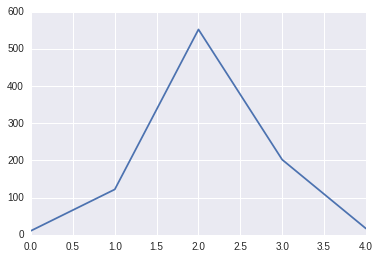

In [45]:
adv_sentiments = [np.sum(np.asarray([1 if j == i else 0\
                                  for j in adverbs['Sentiment']], dtype=int))\
                  for i in range(5)]
plt.plot(adv_sentiments)
plt.show()

In [23]:
def make_phrase_POS_columns(data, parts_of_speech):
    df = data
    for POS in parts_of_speech:
        df[POS] = [np.asarray([1 if p==POS else 0 for p in POS_list], dtype=int)\
                   for POS_list in df['POS']]
    return df

In [24]:
df03 = make_phrase_POS_columns(df02, df02_words01['POS2'].unique())

In [25]:
df03.head()

,SentenceId,Phrase,Sentiment,Negations,POS,DT,NN,IN,NNS,VBG,...,WRB,VBD,JJR,WP$,$,UH,SYM,LS,#,FW
PhraseId,,,,,,,,,,,,,,,,,,,,,
1,1,A series of escapades demonstrating the adage ...,1,A series of escapades demonstrating the adage ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,A series of escapades demonstrating the adage ...,2,A series of escapades demonstrating the adage ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1,A series,2,A series,"[0, 0]","[1, 0]","[0, 1]","[0, 0]","[0, 0]","[0, 0]",...,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
4,1,A,2,A,[0],[1],[0],[0],[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
5,1,series,2,series,[0],[0],[1],[0],[0],[0],...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
